In [1]:
# PGD Attack and Defend on MLP

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import random
num_epochs = 10
batch_size = 64
learning_rate = 0.001
random_seed = 21
random.seed(random_seed)
torch.manual_seed(random_seed)
# Define the MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.fci = nn.Linear(hidden_size, hidden_size)  

    def forward(self, x):
        x = x.view(-1, input_size)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fci(x)  
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 28 * 28  
hidden_size = 128    
num_classes = 10    

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = MLP(input_size, hidden_size, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [2]:
# Train Model on clean Dataset
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [200/938], Loss: 0.3526
Epoch [1/10], Step [400/938], Loss: 0.4109
Epoch [1/10], Step [600/938], Loss: 0.3350
Epoch [1/10], Step [800/938], Loss: 0.1769
Epoch [2/10], Step [200/938], Loss: 0.1021
Epoch [2/10], Step [400/938], Loss: 0.2202
Epoch [2/10], Step [600/938], Loss: 0.2009
Epoch [2/10], Step [800/938], Loss: 0.1313
Epoch [3/10], Step [200/938], Loss: 0.1729
Epoch [3/10], Step [400/938], Loss: 0.0982
Epoch [3/10], Step [600/938], Loss: 0.2879
Epoch [3/10], Step [800/938], Loss: 0.1195
Epoch [4/10], Step [200/938], Loss: 0.0686
Epoch [4/10], Step [400/938], Loss: 0.0138
Epoch [4/10], Step [600/938], Loss: 0.1003
Epoch [4/10], Step [800/938], Loss: 0.1025
Epoch [5/10], Step [200/938], Loss: 0.0630
Epoch [5/10], Step [400/938], Loss: 0.0732
Epoch [5/10], Step [600/938], Loss: 0.0946
Epoch [5/10], Step [800/938], Loss: 0.0837
Epoch [6/10], Step [200/938], Loss: 0.0864
Epoch [6/10], Step [400/938], Loss: 0.1477
Epoch [6/10], Step [600/938], Loss: 0.0185
Epoch [6/10

In [3]:
# Test on clean Dataset
def test_model(data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f'Accuracy on the clean test set: {test_model(test_loader):.2f}%')


Accuracy on the clean test set: 97.21%


test acc 93.75%
test acc 93.75%
test acc 93.75%
test acc 90.625%
test acc 89.0625%
test acc 85.9375%
test acc 82.8125%
test acc 82.8125%
test acc 81.25%
test acc 81.25%


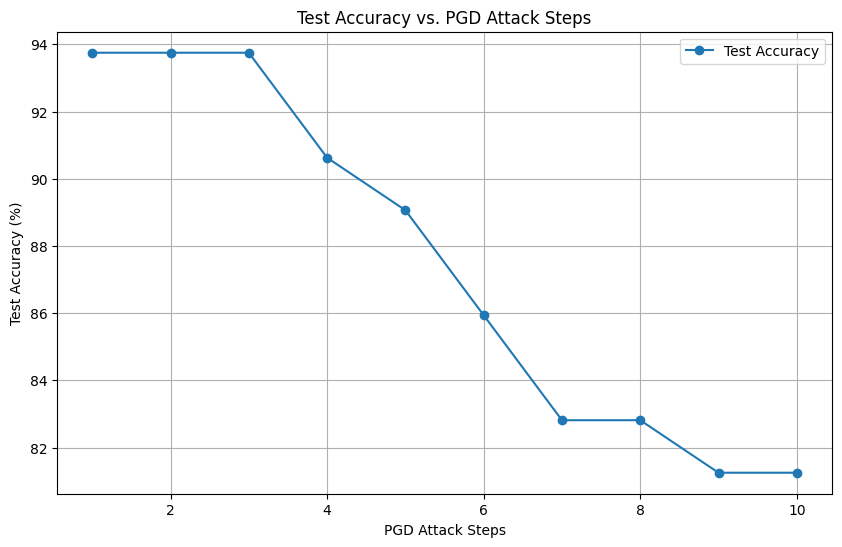

In [4]:
# PGD Attack

import matplotlib.pyplot as plt

def pgd_attack(model, images, labels, eps, alpha, iters):
    adv_images = images.clone().detach()
    original_images = images.clone().detach()
    all_adv_images = []  

    for _ in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        model.zero_grad()
        loss.backward()
        adv_images = adv_images + alpha * adv_images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        adv_images = torch.clamp(original_images + eta, min=0, max=1).detach()
        
        all_adv_images.append(adv_images.clone().detach())  

    return adv_images, all_adv_images

eps = 0.15
alpha = 0.007
iters = 10
step_accuracies = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    _, all_adv_images = pgd_attack(model, images, labels, eps, alpha, iters)
    
    for adv_images in all_adv_images:
        acc = test_model([(adv_images, labels)])
        print(f"test acc {acc}%")
        step_accuracies.append(acc)
    break  

plt.figure(figsize=(10, 6))
plt.plot(range(1, iters + 1), step_accuracies, marker='o', label='Test Accuracy')
plt.title('Test Accuracy vs. PGD Attack Steps')
plt.xlabel('PGD Attack Steps')
plt.ylabel('Test Accuracy (%)')
plt.grid()
plt.legend()
plt.show()

In [5]:
# Defend against PGD

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        adv_images,_ = pgd_attack(model, images, labels, eps, alpha, iters)

        combined_images = torch.cat([images, adv_images], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print(f'Accuracy on the clean test set after adversarial retraining: {test_model(test_loader):.2f}%')
print(f'Accuracy on adversarial examples after adversarial retraining: {test_model([(adv_images, labels)]):.2f}%')


Epoch [1/10], Step [200/938], Loss: 0.1402
Epoch [1/10], Step [400/938], Loss: 0.2761
Epoch [1/10], Step [600/938], Loss: 0.2263
Epoch [1/10], Step [800/938], Loss: 0.1162
Epoch [2/10], Step [200/938], Loss: 0.0220
Epoch [2/10], Step [400/938], Loss: 0.0407
Epoch [2/10], Step [600/938], Loss: 0.0469
Epoch [2/10], Step [800/938], Loss: 0.1793
Epoch [3/10], Step [200/938], Loss: 0.0641
Epoch [3/10], Step [400/938], Loss: 0.0229
Epoch [3/10], Step [600/938], Loss: 0.0194
Epoch [3/10], Step [800/938], Loss: 0.1401
Epoch [4/10], Step [200/938], Loss: 0.0693
Epoch [4/10], Step [400/938], Loss: 0.0198
Epoch [4/10], Step [600/938], Loss: 0.0177
Epoch [4/10], Step [800/938], Loss: 0.0358
Epoch [5/10], Step [200/938], Loss: 0.0145
Epoch [5/10], Step [400/938], Loss: 0.0243
Epoch [5/10], Step [600/938], Loss: 0.0128
Epoch [5/10], Step [800/938], Loss: 0.0121
Epoch [6/10], Step [200/938], Loss: 0.0082
Epoch [6/10], Step [400/938], Loss: 0.0290
Epoch [6/10], Step [600/938], Loss: 0.0087
Epoch [6/10